In [1]:
# 3 classes
'''
Load the datasets for each clas from their numpy files and concatenate them and shuffle. 
The one-hot-encoded labels are shuffled in the exact same arrangement.
'''
import numpy as np

#load numpy binaries
pos = np.load('datasets/cc/batchjob_3_pos.npy')
neg = np.load('datasets/neg7192.npy')
crowded =np.load('datasets/crowded7192.npy')
neg = np.concatenate(( neg, crowded))

#one-hot-encode
py =np.ones((pos.shape[0],1))
for i in range(py.shape[0]): py[i] =[1,]
ny =np.ones((neg.shape[0],1))
for i in range(ny.shape[0]): ny[i] =[0]



#concat the data sets into features and labels
x_combined =np.concatenate((pos, neg))#, paper_pos, paper_neg))#, multisource))
y_combined =np.concatenate((py, ny))#, ppy, pny))#, my)) 

#shuffle the data sets
s3 = np.arange(x_combined.shape[0])
np.random.shuffle(s3)
x_combined_shuf =x_combined[s3]
y_combined_shuf = y_combined[s3]

In [2]:
pos.shape, neg.shape

((14400, 1, 100, 100), (14384, 1, 100, 100))

In [3]:
'''
Load the model files, build architecture, train and sav weights. Save all samples after 50000 for validation.
It might be better ot keep a set completely seperate for validation. 
'''

from HSTLens_resnet16_2_classes import deeplens_classifier

my_model = deeplens_classifier(n_epochs=8, batch_size=32)
my_model._build() 
val=[x_combined_shuf[:10],y_combined_shuf[:10]]
my_model._fit(x_combined_shuf,y_combined_shuf, val)

# my_model.model.save("weights/3_class_weights") # issue with json serializing
my_model.model.save_weights("weights/2_class_weights")
# my_model.model.load_weights("multiclass4_ensemble_1")


Using TensorFlow backend.


building 2 classes
(?, 1, 100, 100)
multiclass_7
pre- resnet block entered!
resnet16 blocks
kernel= 5
shorcut (?, 32, 50, 50) net (?, 32, 50, 50)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 32, 25, 25) net (?, 32, 25, 25)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 64, 25, 25) net (?, 64, 25, 25)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 64, 12, 12) net (?, 64, 12, 12)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 128, 12, 12) net (?, 128, 12, 12)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 128, 6, 6) net (?, 128, 6, 6)
...Fitting model ...
Train on 28784 samples, validate on 10 samples
Epoch 1/8
step decay entered. Learning rate: 0.001
28784/28784 [==============================] - 75s 3ms/step - loss: 0.4213 - acc: 0.8068 - val_loss: 0.1033 - val_acc: 1.0000
Epoch 2/8
step decay entered. Learning rate: 0.001
28784/28784 [==============================] - 71s 2ms/step - loss: 0.224

[0.]


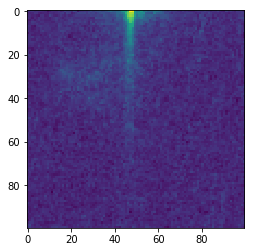

curr num 347next=1, exit=00


In [7]:
 #quickly view some images

import matplotlib.pyplot as plt
from IPython import display
import os

ims =  x_combined_shuf #numpy array to view
y = y_combined_shuf #corresponding labels

print(len(ims))
sp=int(input("start position"))


for i in range(len(ims)):
    exit=False
    display.clear_output(wait=True)
    plt.imshow(ims[i+sp][0]) 
    print(y[i+sp])
    plt.pause(0.01)
    plt.show()
    while(1):      
        ans = int(input("curr num "+str(i+sp)+"next=1, exit=0"))
        if ans ==1: 
            break
        if ans==0:
            exit=True
            break
    if exit==True:
        break

In [16]:
#plot ROC curve only works for binary classification
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

fpr, tpr, t=my_model.eval_ROC(x_combined_shuf[50000:],y_combined_shuf[50000:])
print("auc "+str( metrics.auc(fpr, tpr)))

plt.title('4 classes')
plt.plot(fpr,tpr)
plt.xlabel('FPR'); 
plt.ylabel('TPR')
plt.xlim(0,0.4); 
plt.ylim(0.8,1)
plt.grid('on')

ValueError: multilabel-indicator format is not supported

/project/6016730/mlhaa/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


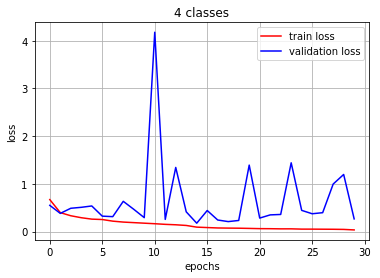

In [9]:
#plot the loss vs epochs
#my_model.model.history is a callback obj my_model.model.history is a dict
import matplotlib.pyplot as plt
train_loss = my_model.model.history.history['loss'] 
val_loss = my_model.model.history.history['val_loss']
xc = range(30)

plt.figure()
plt.title('4 classes')
plt.xlabel('epochs');
plt.ylabel('loss')
plt.plot(xc, train_loss,'r-',label="train loss")
plt.plot(xc, val_loss, 'b-',label="validation loss")
plt.grid('on')
plt.legend()

/project/6016730/mlhaa/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


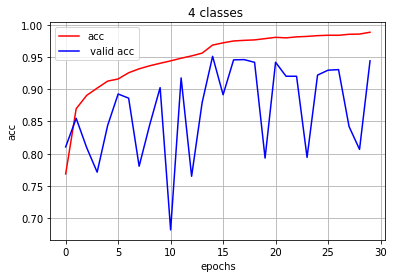

In [10]:
#plot training accuracy
import matplotlib.pyplot as plt
acc = my_model.model.history.history['acc'] 
val_acc = my_model.model.history.history['val_acc'] 
xc =range(30)
plt.figure()
plt.title('4 classes ')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.plot(xc, acc,'r-',label="acc")
plt.plot(xc, val_acc,'b-',label=" valid acc")
plt.grid('on')
plt.legend()

In [8]:
#get predictions using an ensemble of models
import numpy as np
import os 
from HSTLens_resnet16_3_classes import deeplens_classifier

hm_models=3
TEST_SET_PATH='real_clean_norm_paper.npy'
WEIGHTS_PATH = "/home/toyonaga/projects/def-sfabbro/toyonaga/HSTLens/CC_batch_processing/batchjob3_weights/" #ensembleweights_"

test_set = np.load(TEST_SET_PATH)

weight_names = os.listdir(WEIGHTS_PATH)

my_models = []
for model in range(int(hm_models)):
    my_models.append(deeplens_classifier())
    my_models[model]._build() #should not accept arguments
    my_models[model].model.load_weights(WEIGHTS_PATH+weight_names[model])

    
predictions =[]
for model in range(int(hm_models)):
    print(model)
    predictions.append(my_models[model]._predict(test_set, y= None, discrete = False))


Using TensorFlow backend.


building 3 classes
(?, 1, 100, 100)
multiclass_7
pre- resnet block entered!
resnet16 blocks
kernel= 5
shorcut (?, 32, 50, 50) net (?, 32, 50, 50)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 32, 25, 25) net (?, 32, 25, 25)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 64, 25, 25) net (?, 64, 25, 25)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 64, 12, 12) net (?, 64, 12, 12)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 128, 12, 12) net (?, 128, 12, 12)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 128, 6, 6) net (?, 128, 6, 6)
building 3 classes
(?, 1, 100, 100)
multiclass_7
pre- resnet block entered!
resnet16 blocks
kernel= 5
shorcut (?, 32, 50, 50) net (?, 32, 50, 50)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 32, 25, 25) net (?, 32, 25, 25)
pre- resnet block entered!
resnet16 blocks
kernel= 3
shorcut (?, 64, 25, 25) net (?, 64, 25, 25)
pre- resnet block entered!
re

In [11]:
#quickly get predicitons using 1 model only
predictions  = my_model._predict( x_combined_shuf[50000:], y= None, discrete = False)
y=y_combined_shuf[50000:]


...Generating Predictions ...


Confusion matrix, without normalization
[[1819   47   16   11]
 [  32 1804   14   64]
 [  22   14 1867  103]
 [   3   86   20 1662]]
Normalized confusion matrix
[[0.96 0.02 0.01 0.01]
 [0.02 0.94 0.01 0.03]
 [0.01 0.01 0.93 0.05]
 [0.   0.05 0.01 0.94]]


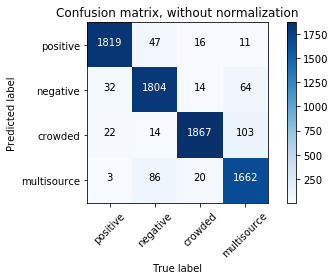

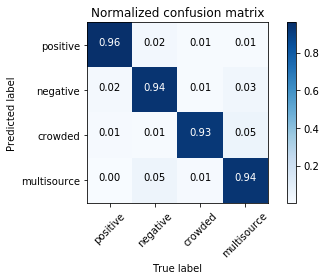

In [12]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.tight_layout()

class_names = ['positive','negative', 'crowded', 'multisource']
flat_pred = []
flat_true = []
for i in predictions:
    flat_pred.append(np.argmax(i))
                     
for i in y:
    flat_true.append(np.argmax(i))  
    
# Compute confusion matrix
cnf_matrix = confusion_matrix( flat_pred,flat_true)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [45]:
#get ROC curve...in progress
import numpy as np
from sklearn.metrics import roc_curve
from random import randint

roc_pred = np.zeros( (100,1))# (predictions.shape[0]))
roc_y = np.zeros((100,1))#(y.shape[0]))

for i in range(roc_pred.shape[0]):
    if randint(0,1)+0.5 >0: #np.argmax(y[i]) > 0: 
        roc_y[i] = np.array([1])
    else: 
        roc_y[i] = np.array([0])
    
    if randint(0,1)+0.5 >0:#  np.argmax(predictions[i]) > 0: 
        roc_pred[i] =  np.array([float(randint(0,1))/100])
    else: 
        roc_pred[i] =  np.array([float(randint(0,1))/100])


        
fpr, tpr, t = roc_curve(roc_y, roc_pred.ravel())

/project/6016730/mlhaa/lib/python3.6/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
